In [1]:
%matplotlib inline
import pandas as pd
import librosa as lib
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio
import scipy

In [2]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit, train_test_split, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

In [3]:
#importing project created functions, these can be found in model_prep folder in repo
from model_prep import Xy_prep_all, Xy_prep_silence, Xy_prep_music, cross_val_time

In [4]:
from dask import dataframe as dd
import joblib
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
cluster.scheduler, cluster.workers

(<Scheduler: "tcp://127.0.0.1:64634" processes: 3 cores: 6>,
 {0: <Nanny: tcp://127.0.0.1:64653, threads: 2>,
  1: <Nanny: tcp://127.0.0.1:64659, threads: 2>,
  2: <Nanny: tcp://127.0.0.1:64656, threads: 2>})

In [5]:
model_data = pd.read_pickle('DFs/model_data.pkl')

In [6]:
pca = PCA()
scaler = StandardScaler()

scaled = pd.DataFrame(scaler.fit_transform(model_data.drop(columns=['segment', 'SID', 'PID'])), 
                      columns=model_data.drop(columns=['segment', 'SID', 'PID']).columns)
with joblib.parallel_backend('dask'):
    pca.fit(scaled)

In [7]:
ex = pca.explained_variance_ratio_

In [8]:
exdf = pd.DataFrame(ex.reshape(1, -1), columns=range(len(ex)))
exdf.T.rename(columns={0:'variance_explained'}).head(15)

,variance_explained
0,0.235418
1,0.075339
2,0.025955
3,0.023623
4,0.019229
5,0.018930
6,0.017938
7,0.017344
8,0.016356
9,0.013854


In [9]:
pca10 = PCA(n_components=10)
scaled = pd.DataFrame(scaler.fit_transform(model_data.drop(columns=['segment', 'SID', 'PID'])), 
                      columns=model_data.drop(columns=['segment', 'SID', 'PID']).columns)
model_pca = pca.fit_transform(scaled)

We can run an out of the box elasticNet on the PCA transformed model_data to see how it performs

In [27]:
def Xy_prep_all(df, target, train_a=1, train_b=50, test_a=51, test_b=75):
    
    #Select proper participants for training
    df_train = df.loc[df['PID'].between(train_a, train_b)]
    #Select only musical sections
    df_train = df_train.iloc[(int(len(df_train)/2)):,:]
    #columns to drop from X
    drop_cols = ['PID', 'SID', 'target_1_sec', 'X', 'Y','Z', 'segment']
    #set milliseconds as index
    df_train = df_train.set_index('millisecond')
    #participants = b-a+1
    #
    train_X = df_train.drop(columns=drop_cols)#.to_numpy()
    train_y = df_train[target]#.to_numpy()
    #store column names
    #cols = df_train.drop(columns=drop_cols).columns
    #participants = b-a+1
    #Select proper participants for training
    df_test = df.loc[df['PID'].between(test_a, test_b)]
    #Select only musical sections
    df_test = df_test.iloc[(int(len(df_train)/2)):,:]
    #columns to drop from X
    drop_cols = ['PID', 'SID', 'target_1_sec', 'X', 'Y','Z', 'segment']
    #set milliseconds as index
    df_test = df_test.set_index('millisecond')
    #participants = b-a+1
    #
    test_X = df_test.drop(columns=drop_cols)#.to_numpy()
    test_y = df_test.loc[:,[target,'PID']]#.to_numpy()
    
    return train_X, test_X, train_y, test_y#, cols#, participants

In [29]:
#Create column lists to use as inputs for the StandardScaler and OneHotEncoder Pipeline
num_cols = list(train_X.columns[-10:])
num_cols.extend(['Height', 'Age', 'Listen', 'Produce', 'Dance', 'Exercise'])
cat_cols = ['Tiresome', 'age_bin', 'height_bin']

In [30]:
#Set up instances of StanardSCaler, OneHotEncoder and ColumnTransformer to process model_data
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore')
CT = ColumnTransformer(remainder='passthrough', transformers=[('scaler', scaler, num_cols),
                                              ('ohe', ohe, cat_cols)], verbose=True, sparse_threshold=0)

In [31]:
def get_feature_name(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    import warnings
    import sklearn
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names


In [133]:
train_X, test_X, train_y, test_y = Xy_prep_all(model_data, 'target_1_sec', 
                                                                             train_a=15, train_b=25, test_a=30, test_b=35)

In [134]:
train_Xct = CT.fit_transform(train_X)
    
#transform test data based on training fit
test_Xct = CT.transform(test_X)

#get columns names from ColumnTransformer
cols = get_feature_name(CT)
train_Xf = pd.DataFrame(train_Xct, columns=cols)
cols = get_feature_name(CT)
test_Xf = pd.DataFrame(test_Xct, columns=cols)

[ColumnTransformer] ........ (1 of 3) Processing scaler, total=   0.1s
[ColumnTransformer] ........... (2 of 3) Processing ohe, total=   0.0s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


<ipython-input-31-8740127314b0>:32: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


# ElasticNet 10 Components

In [156]:
elastic = ElasticNet()
pca10 = PCA(n_components=10)
train_X = pca10.fit_transform(train_Xf)
test_X = pca10.transform(test_Xf)
elastic.fit(train_X, train_y)

ElasticNet()

In [157]:
par_scores = {'par':[],'pred':[], 'true':[],'MAPE':[]}
for par in range(30,36):
    mask = test_y.reset_index(drop=True)['PID']==par
    pred_X = test_X[mask.values,:]
    y_pred = elastic.predict(pred_X)
    y_true = test_y.loc[test_y['PID']==par, 'target_1_sec'].to_numpy()
    par_scores['par'].append(par)
    par_scores['pred'].append(y_pred)
    par_scores['true'].append(y_true)
    
    MAPE = mean_absolute_percentage_error(y_true, y_pred)
    par_scores['MAPE'].append(MAPE)

par_scores_df = pd.DataFrame(par_scores)   
par_scores_df[['par', 'MAPE']]

,par,MAPE
0,30,0.320895
1,31,0.455132
2,32,0.516028
3,33,0.428341
4,34,0.411894
5,35,0.404693


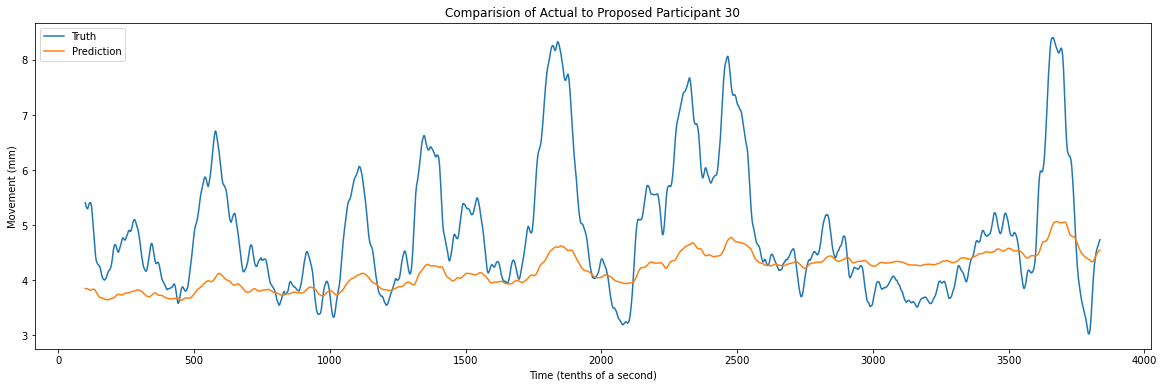

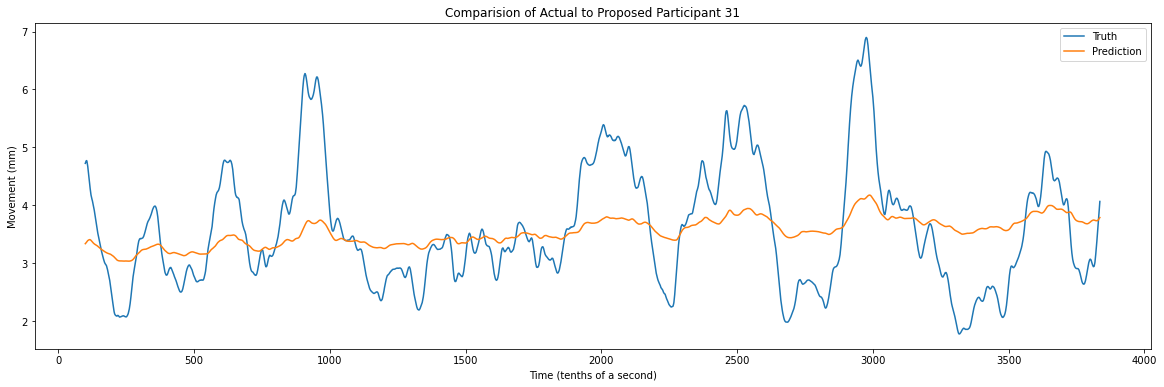

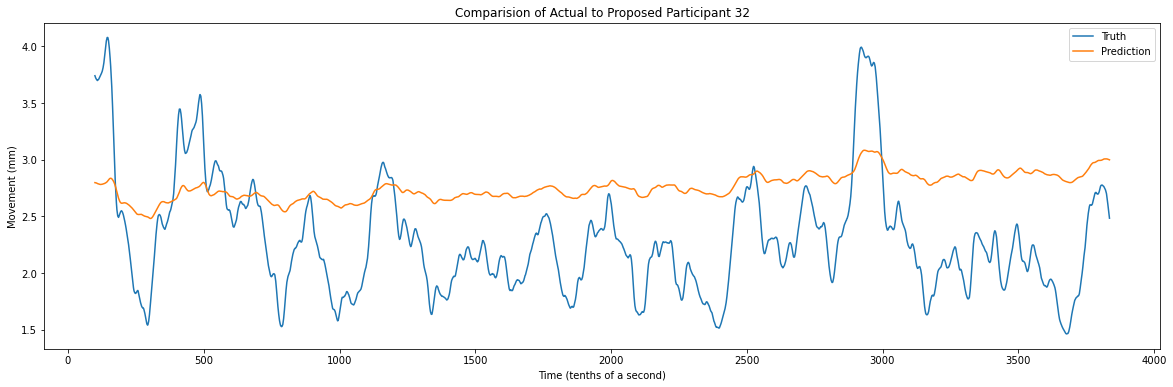

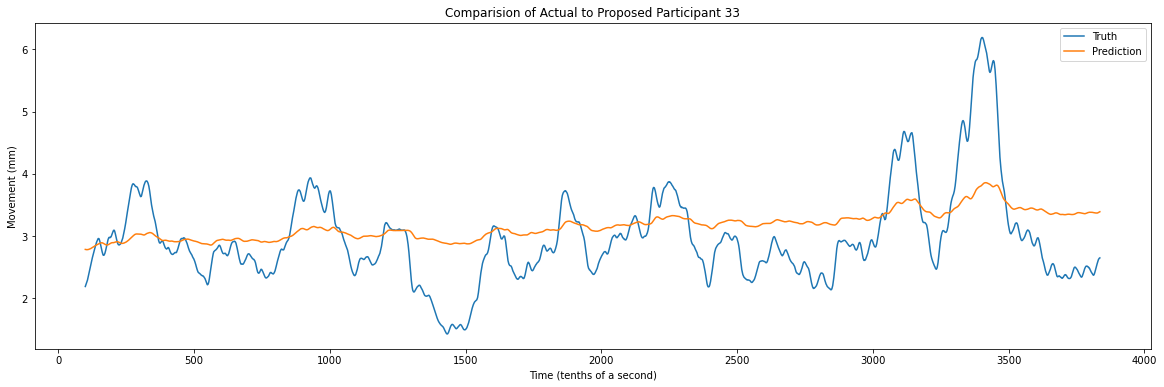

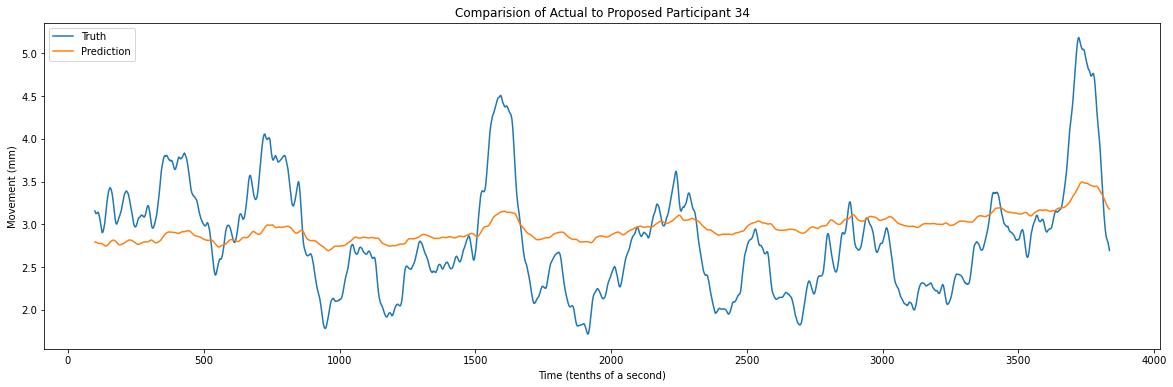

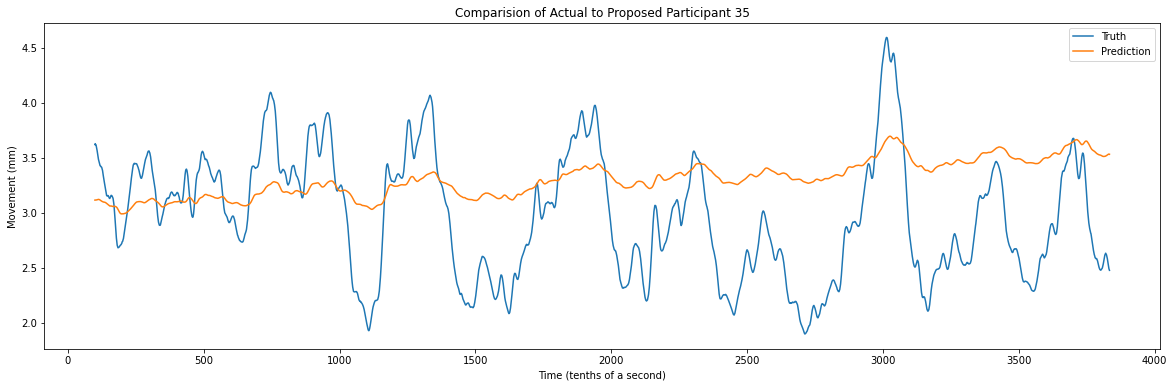

In [158]:
ind = 0
for par in range(30,36):
    
    prediction = par_scores_df.loc[par_scores_df['par']==par, 'pred'][ind]
    truth = par_scores_df.loc[par_scores_df['par']==par, 'true'][ind]
    compare = pd.DataFrame({'Truth':truth, 'Prediction':prediction})
    compare.rolling(100).mean().plot(figsize=(20,6))
    plt.title('Comparision of Actual to Proposed Participant {}'.format(par))
    plt.xlabel('Time (tenths of a second)')
    plt.ylabel('Movement (mm)')
    plt.show()
    ind +=1

# ElasticNet 200 Components

In [159]:
elastic = ElasticNet()
pca10 = PCA(n_components=200)
train_X = pca10.fit_transform(train_Xf)
test_X = pca10.transform(test_Xf)
elastic.fit(train_X, train_y)

ElasticNet()

In [160]:
par_scores = {'par':[],'pred':[], 'true':[],'MAPE':[]}
for par in range(30,36):
    mask = test_y.reset_index(drop=True)['PID']==par
    pred_X = test_X[mask.values,:]
    y_pred = elastic.predict(pred_X)
    y_true = test_y.loc[test_y['PID']==par, 'target_1_sec'].to_numpy()
    par_scores['par'].append(par)
    par_scores['pred'].append(y_pred)
    par_scores['true'].append(y_true)
    
    MAPE = mean_absolute_percentage_error(y_true, y_pred)
    par_scores['MAPE'].append(MAPE)

par_scores_df = pd.DataFrame(par_scores)   
par_scores_df[['par', 'MAPE']]

,par,MAPE
0,30,0.320895
1,31,0.455132
2,32,0.516028
3,33,0.428341
4,34,0.411894
5,35,0.404693


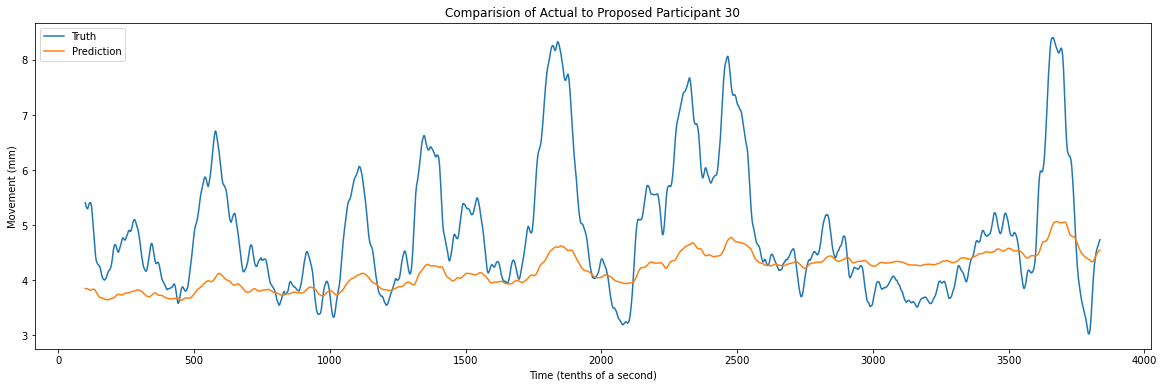

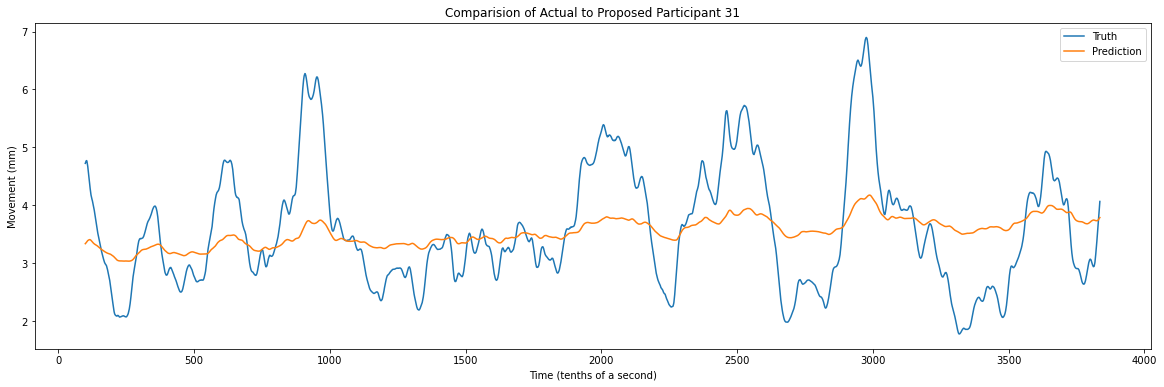

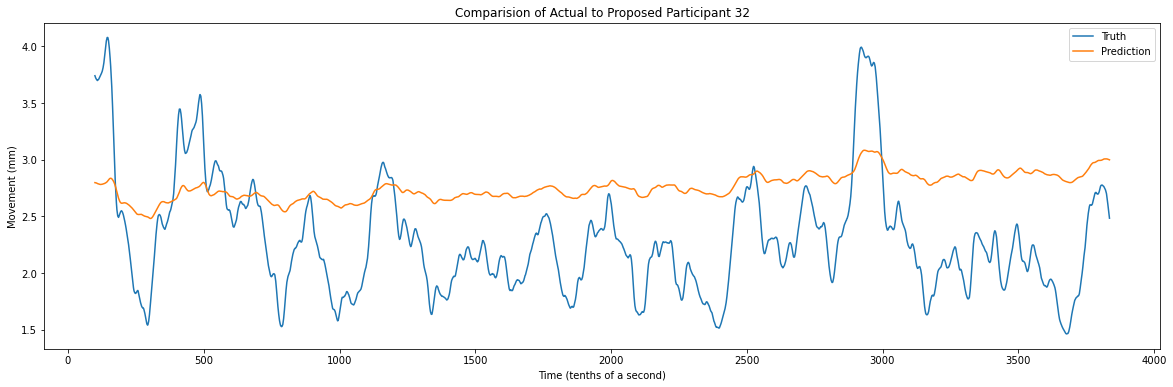

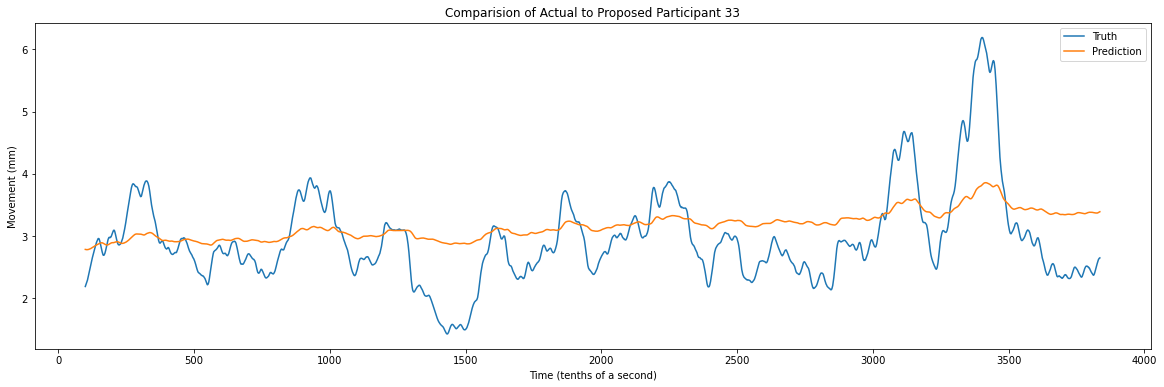

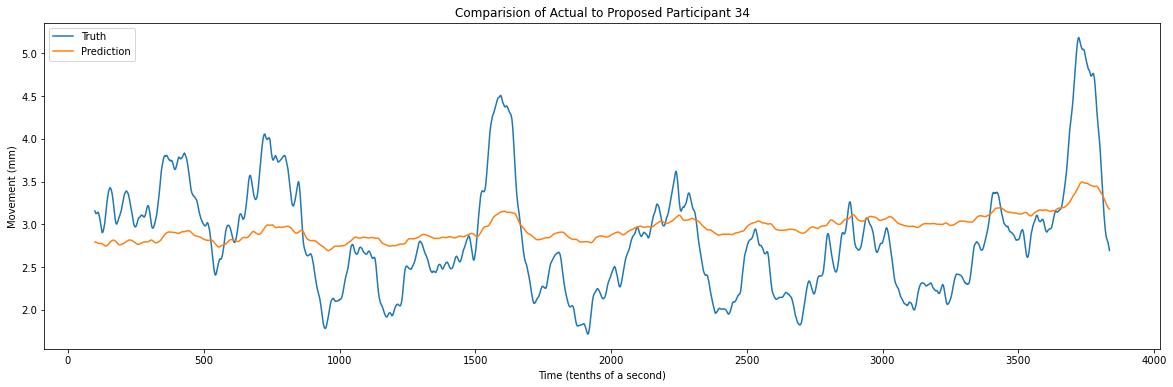

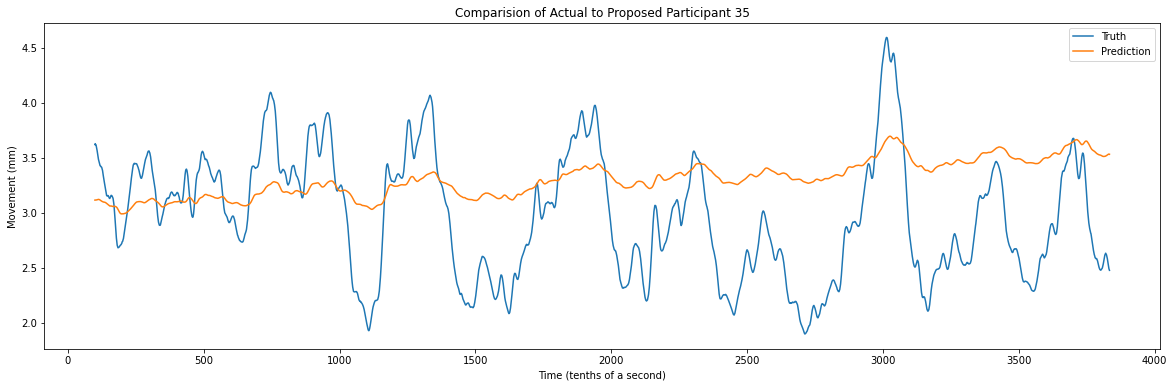

In [161]:
ind = 0
for par in range(30,36):
    
    prediction = par_scores_df.loc[par_scores_df['par']==par, 'pred'][ind]
    truth = par_scores_df.loc[par_scores_df['par']==par, 'true'][ind]
    compare = pd.DataFrame({'Truth':truth, 'Prediction':prediction})
    compare.rolling(100).mean().plot(figsize=(20,6))
    plt.title('Comparision of Actual to Proposed Participant {}'.format(par))
    plt.xlabel('Time (tenths of a second)')
    plt.ylabel('Movement (mm)')
    plt.show()
    ind +=1

# ElasticNet All Components

In [143]:
elastic = ElasticNet()
elastic.fit(train_Xf, train_y)

ElasticNet()

In [144]:
par_scores = {'par':[],'pred':[], 'true':[],'MAPE':[]}
for par in range(30,36):
    mask = test_y.reset_index(drop=True)['PID']==par
    pred_X = test_Xf.loc[mask]
    y_pred = elastic.predict(pred_X)
    y_true = test_y.loc[test_y['PID']==par, 'target_1_sec'].to_numpy()
    par_scores['par'].append(par)
    par_scores['pred'].append(y_pred)
    par_scores['true'].append(y_true)
    
    MAPE = mean_absolute_percentage_error(y_true, y_pred)
    par_scores['MAPE'].append(MAPE)

par_scores_df = pd.DataFrame(par_scores)   
par_scores_df[['par', 'MAPE']]

,par,MAPE
0,30,0.326578
1,31,0.460094
2,32,0.526042
3,33,0.428845
4,34,0.403663
5,35,0.411080


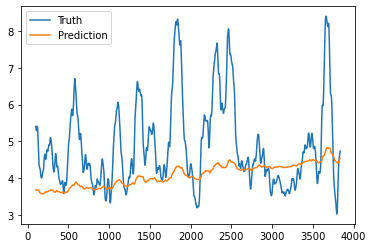

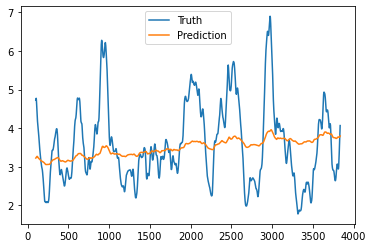

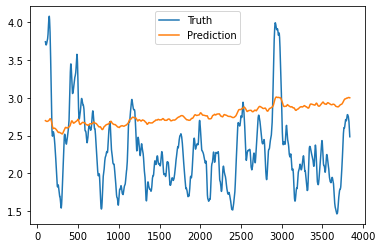

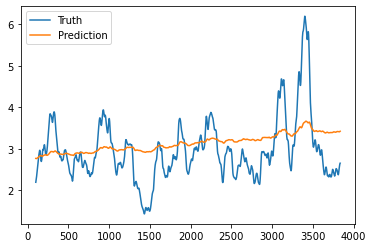

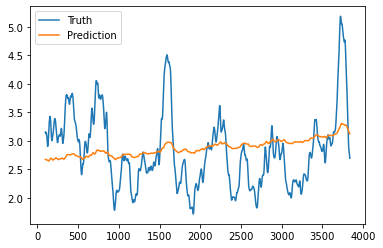

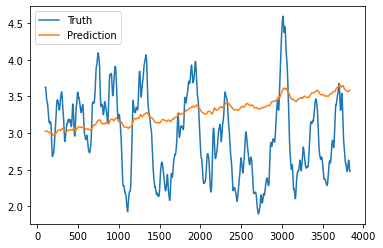

In [145]:
ind = 0
for par in range(30,36):
    
    prediction = par_scores_df.loc[par_scores_df['par']==par, 'pred'][ind]
    truth = par_scores_df.loc[par_scores_df['par']==par, 'true'][ind]
    compare = pd.DataFrame({'Truth':truth, 'Prediction':prediction})
    compare.rolling(100).mean().plot()
    plt.show()
    ind +=1

# Random Forest OBO

In [147]:
rf = RandomForestRegressor(verbose=True)
with joblib.parallel_backend('dask'):
    rf.fit(train_Xf, train_y)

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.8min finished


In [148]:
par_scores = {'par':[],'pred':[], 'true':[],'MAPE':[]}
for par in range(30,36):
    mask = test_y.reset_index(drop=True)['PID']==par
    test_X = test_Xf.loc[mask]
    y_pred = rf.predict(test_X)
    y_true = test_y.loc[test_y['PID']==par, 'target_1_sec'].to_numpy()
    par_scores['par'].append(par)
    par_scores['pred'].append(y_pred)
    par_scores['true'].append(y_true)
    
    MAPE = mean_absolute_percentage_error(y_true, y_pred)
    par_scores['MAPE'].append(MAPE)
    r2 = rf.score(y_true, y_pred)

par_scores_df = pd.DataFrame(par_scores)   
par_scores_df[['par', 'MAPE']]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


,par,MAPE
0,30,0.274355
1,31,0.352939
2,32,0.422114
3,33,0.326676
4,34,0.301685
5,35,0.311196


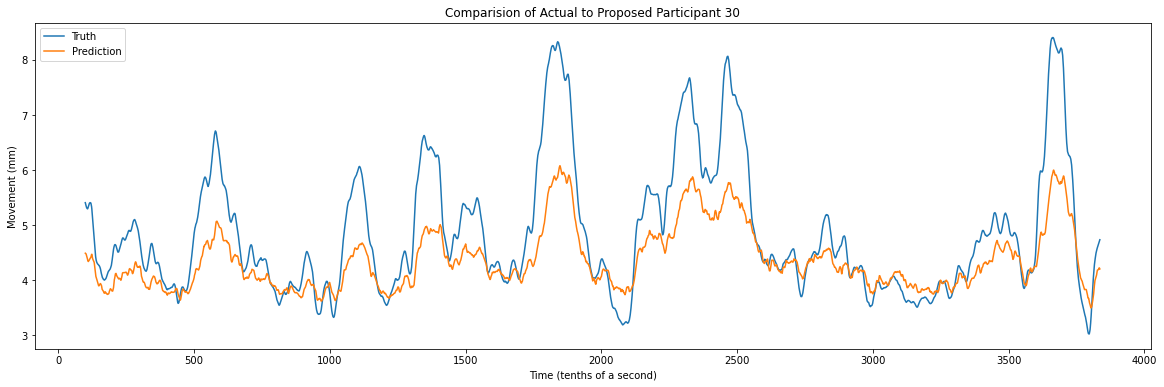

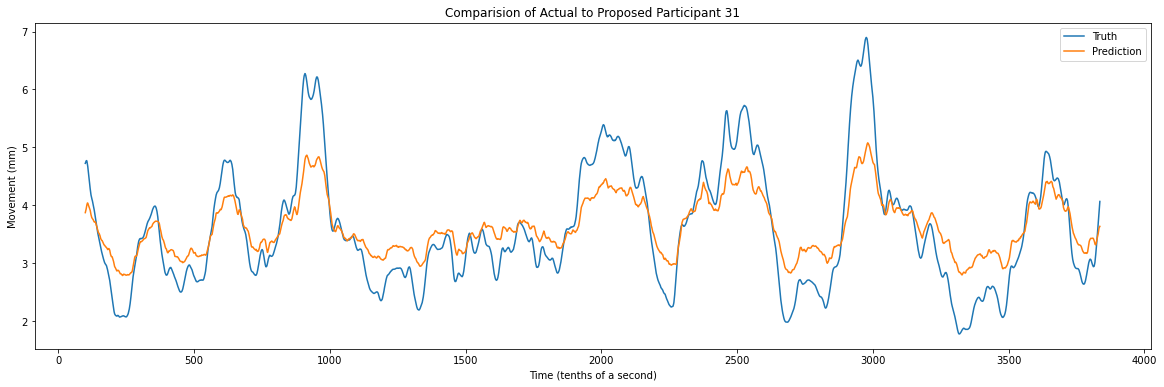

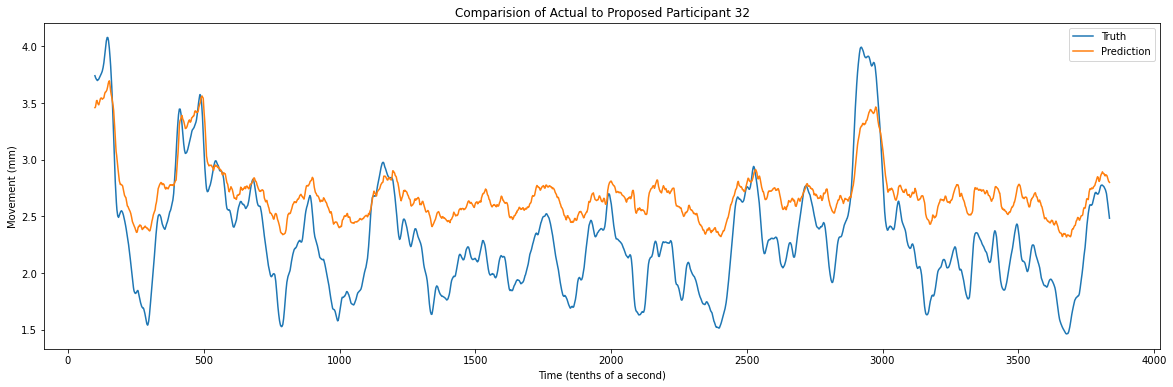

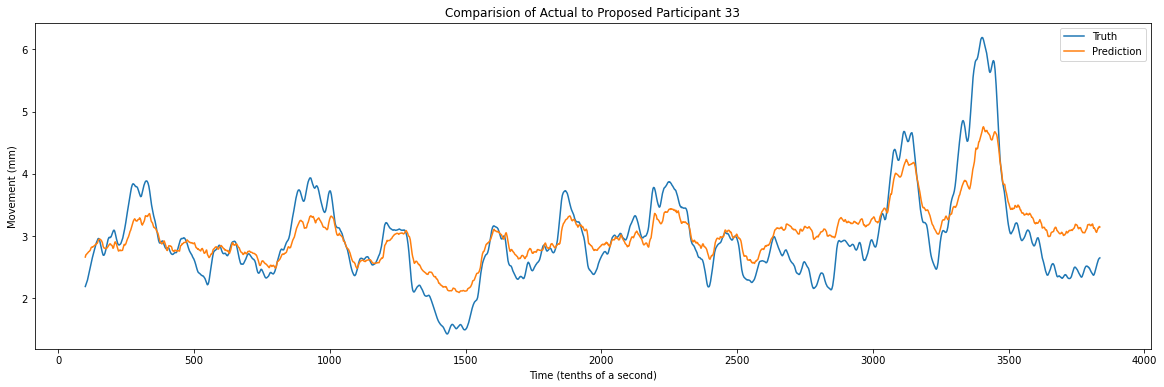

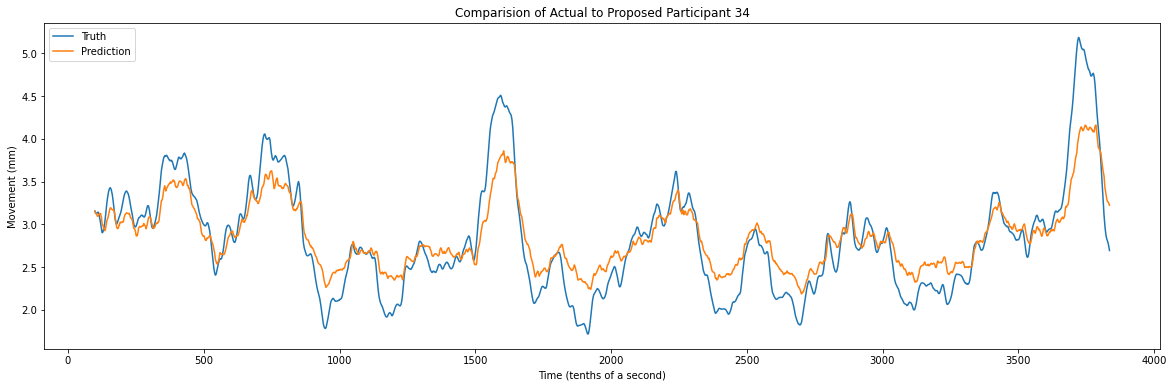

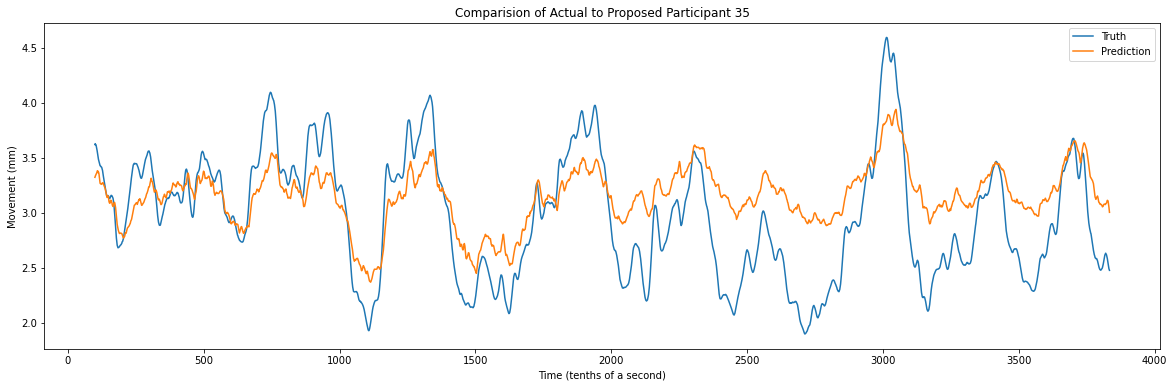

In [153]:
ind = 0
for par in range(30,36):
    prediction = par_scores_df.loc[par_scores_df['par']==par, 'pred'][ind]
    truth = par_scores_df.loc[par_scores_df['par']==par, 'true'][ind]
    compare = pd.DataFrame({'Truth':truth, 'Prediction':prediction})
    compare.rolling(100).mean().plot(figsize=(20, 6))
    plt.title('Comparision of Actual to Proposed Participant {}'.format(par))
    plt.xlabel('Time (tenths of a second)')
    plt.ylabel('Movement (mm)')
    plt.show()
    ind +=1

# Random Forest 50 estimators, all participants split test size about 25%

In [162]:
train_X, test_X, train_y, test_y = Xy_prep_all(model_data, 'target_1_sec', 
                                                                             train_a=0, train_b=55, test_a=56, test_b=75)

In [163]:
train_Xct = CT.fit_transform(train_X)
    
#transform test data based on training fit
test_Xct = CT.transform(test_X)

#get columns names from ColumnTransformer
cols = get_feature_name(CT)
train_Xf = pd.DataFrame(train_Xct, columns=cols)
cols = get_feature_name(CT)
test_Xf = pd.DataFrame(test_Xct, columns=cols)

[ColumnTransformer] ........ (1 of 3) Processing scaler, total=   0.2s
[ColumnTransformer] ........... (2 of 3) Processing ohe, total=   0.1s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


<ipython-input-31-8740127314b0>:32: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


In [164]:
rf = RandomForestRegressor(n_estimators=50, verbose=True)
with joblib.parallel_backend('dask'):
    rf.fit(train_Xf, train_y)

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed: 25.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 32.6min finished


In [167]:
test_y['PID'].unique()

array([71, 74, 63, 64, 61, 65, 59, 72, 73, 62, 70, 58, 60, 67, 57, 68, 69,
       66], dtype=int64)

In [169]:
par_scores = {'par':[],'pred':[], 'true':[],'MAPE':[]}
for par in test_y['PID'].unique():
    print(par)
    mask = test_y.reset_index(drop=True)['PID']==par
    test_X = test_Xf.loc[mask]
    y_pred = rf.predict(test_X)
    y_true = test_y.loc[test_y['PID']==par, 'target_1_sec'].to_numpy()
    par_scores['par'].append(par)
    par_scores['pred'].append(y_pred)
    par_scores['true'].append(y_true)
    
    MAPE = mean_absolute_percentage_error(y_true, y_pred)
    par_scores['MAPE'].append(MAPE)
    #r2 = rf.score(y_true, y_pred)

par_scores_df = pd.DataFrame(par_scores)   
par_scores_df[['par', 'MAPE']]

71
74


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


63
64


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


61
65
59


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


72
73


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


62
70
58


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


60
67


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


57
68
69


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


66


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


,par,MAPE
0,71,0.317174
1,74,0.375571
2,63,0.367146
3,64,0.428666
4,61,0.346065
5,65,0.323626
6,59,0.283930
7,72,0.403321
8,73,0.289198
9,62,0.301196


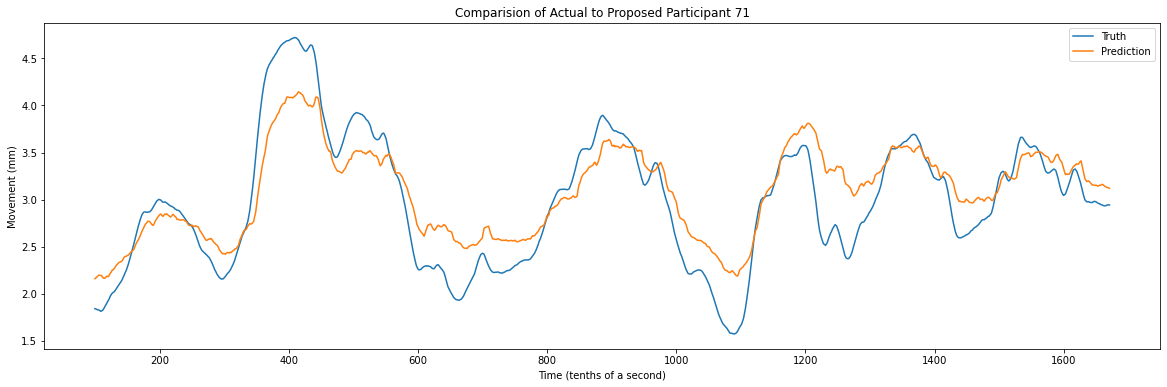

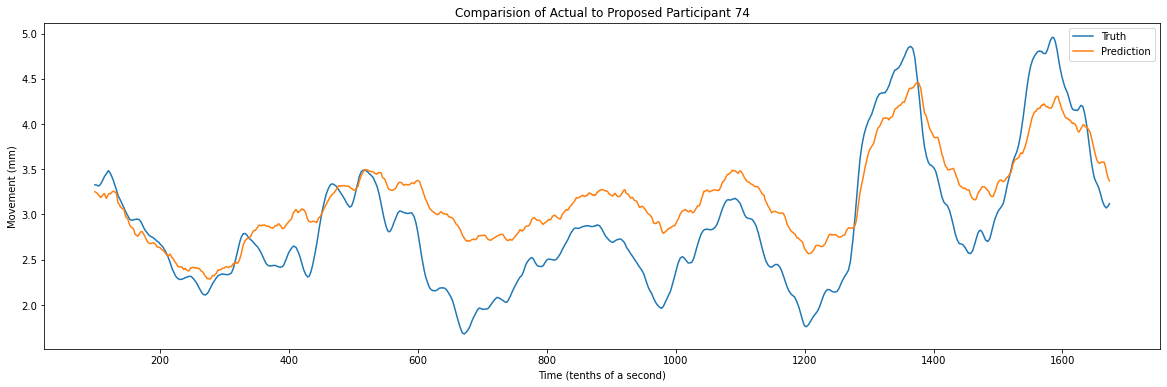

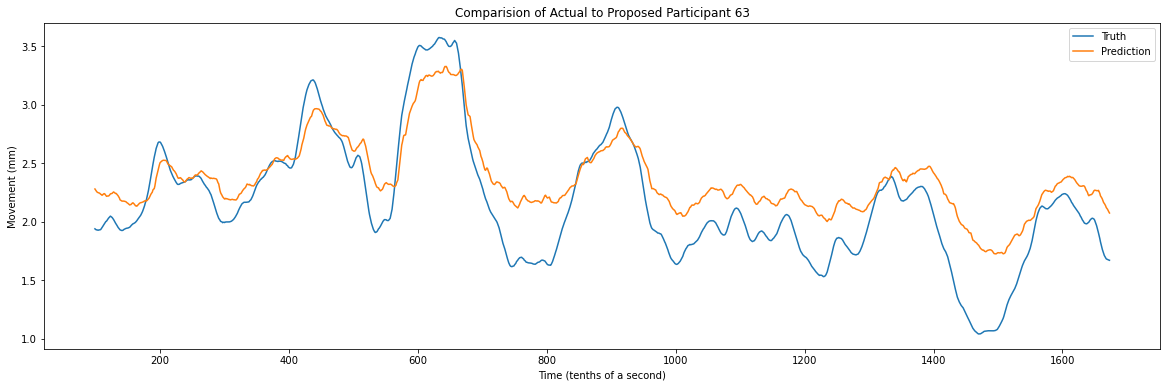

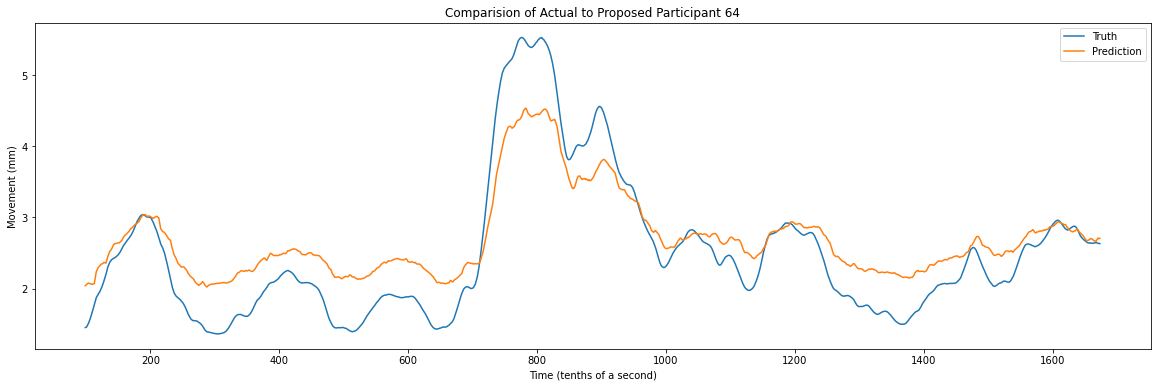

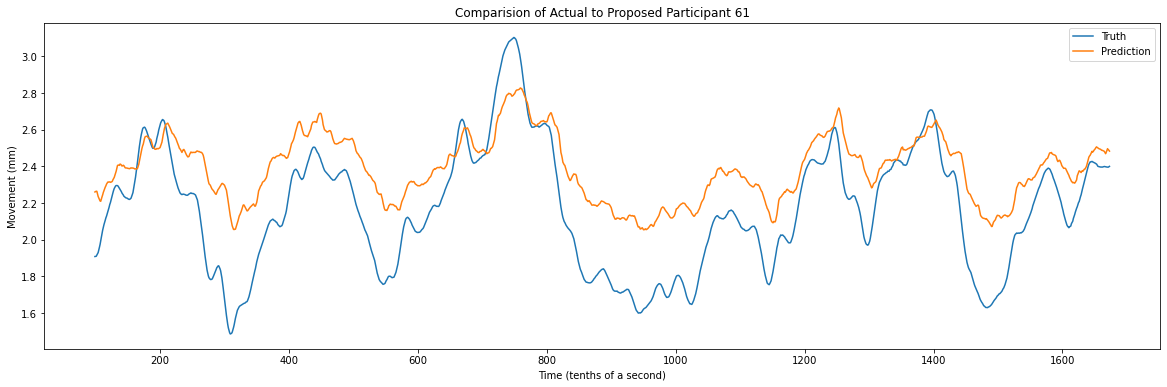

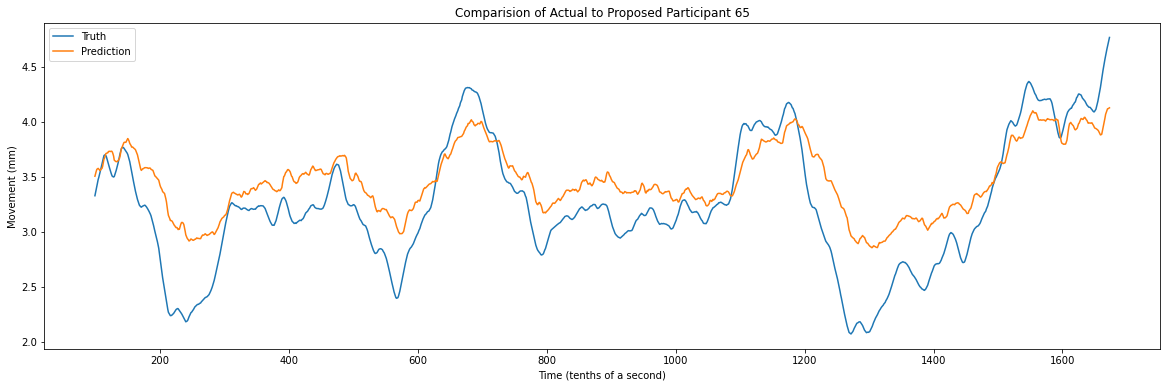

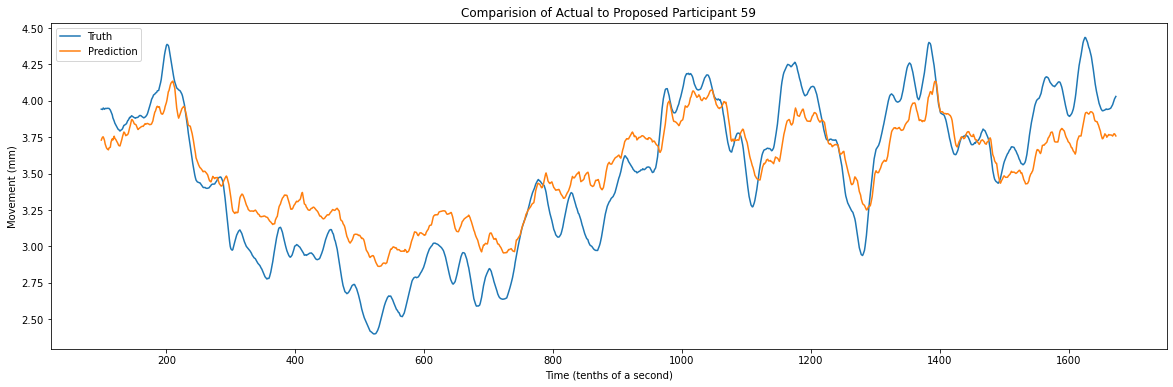

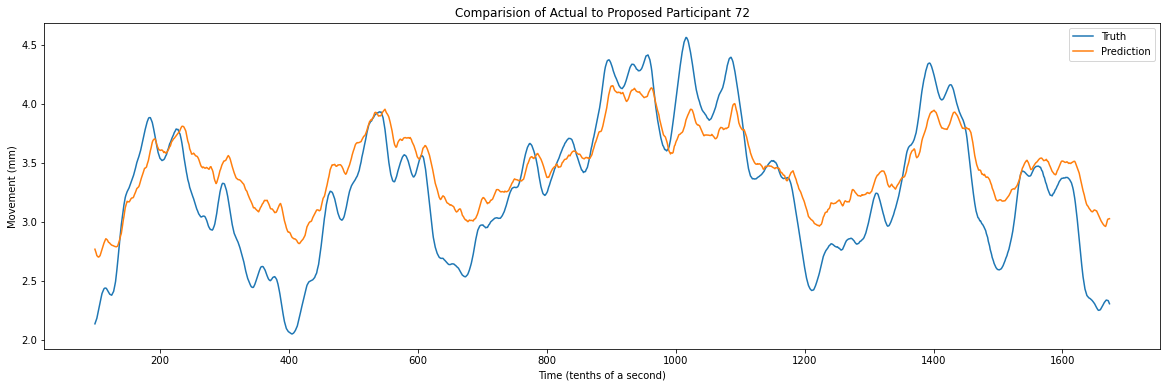

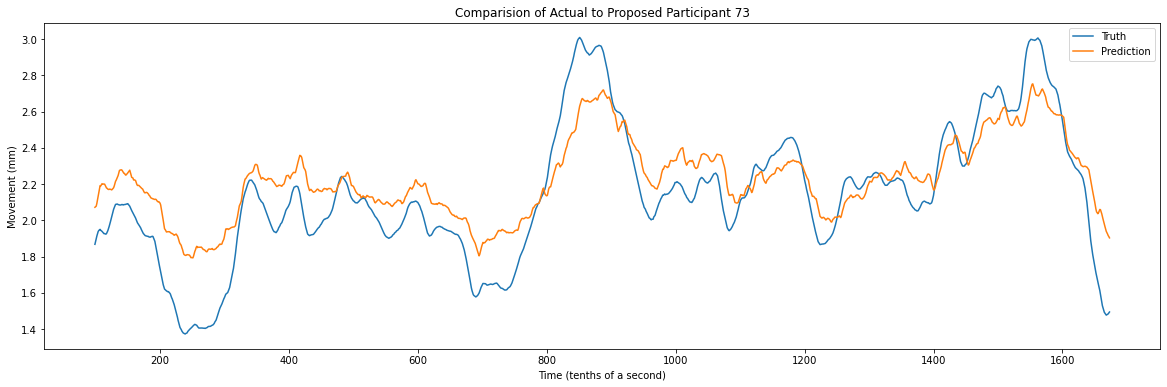

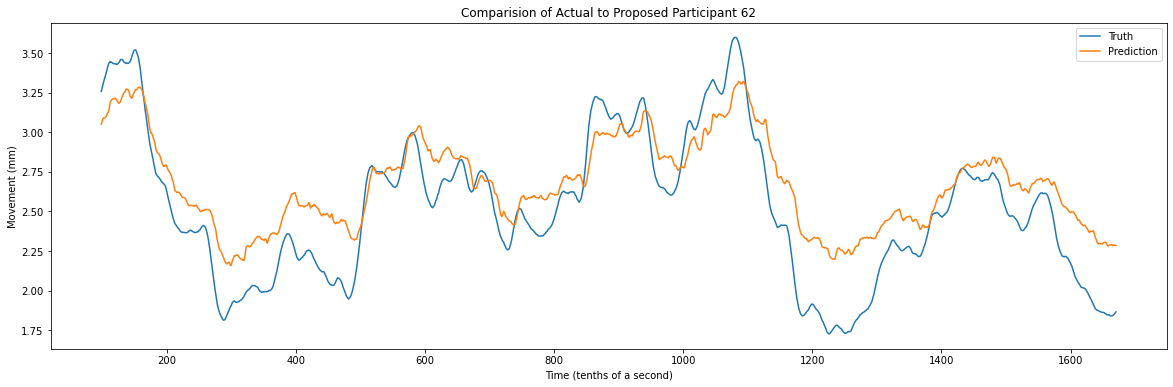

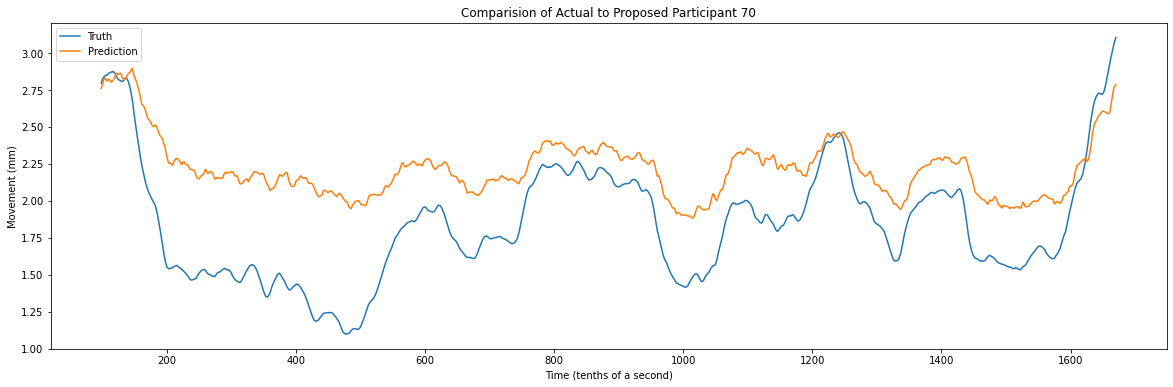

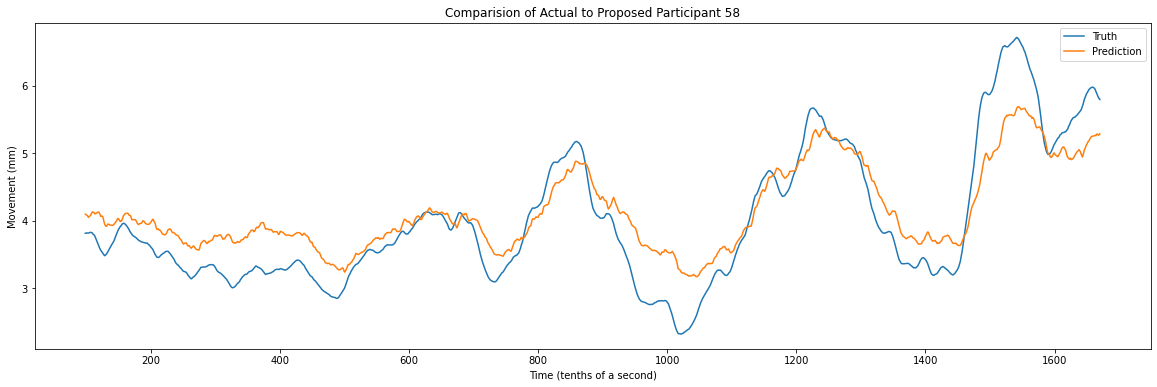

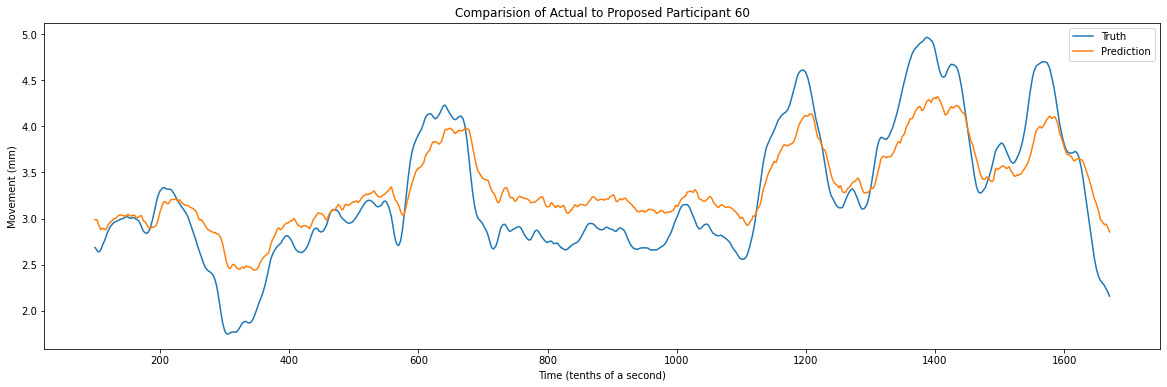

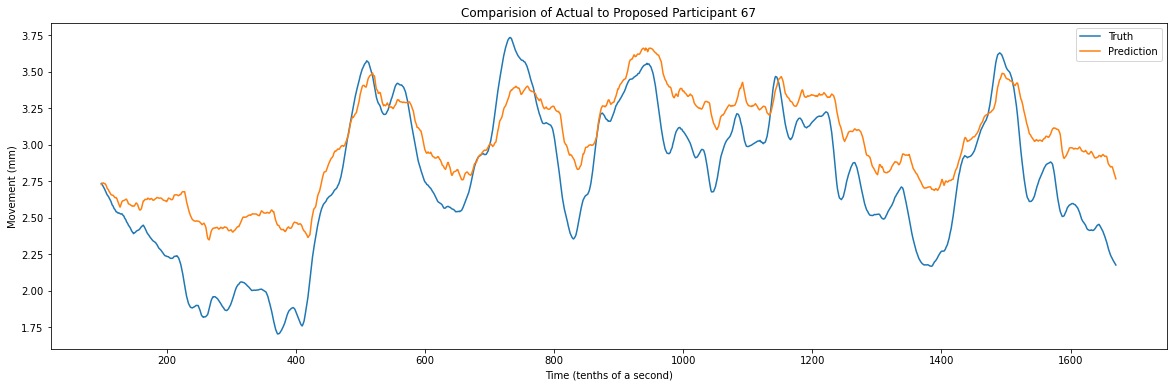

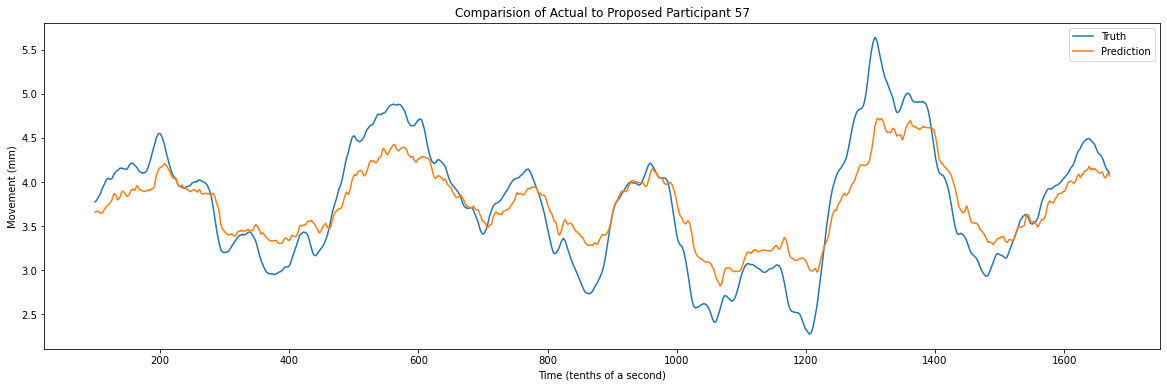

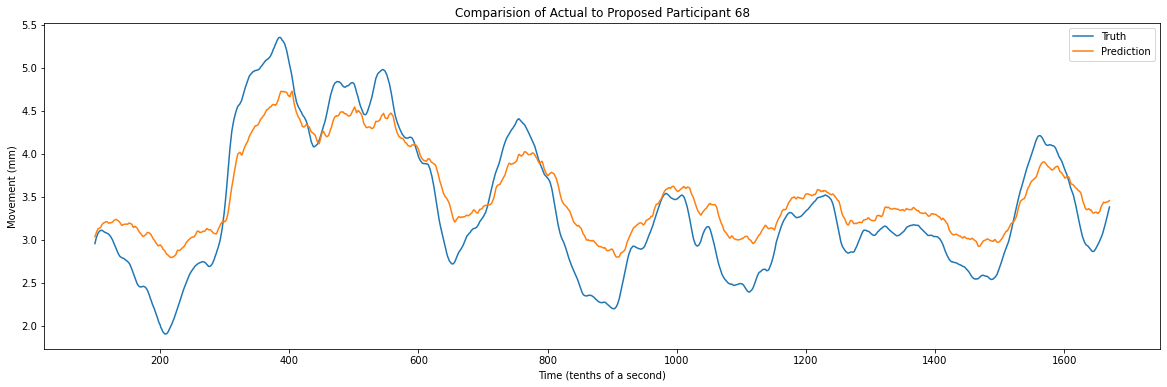

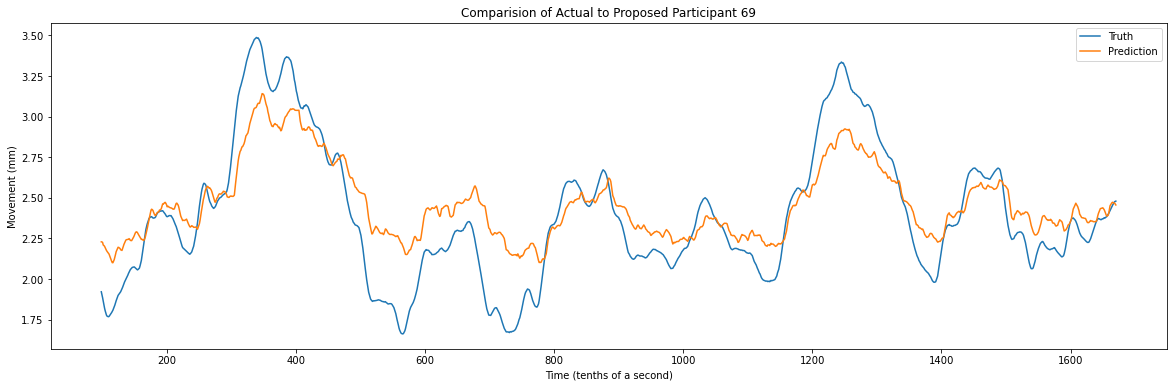

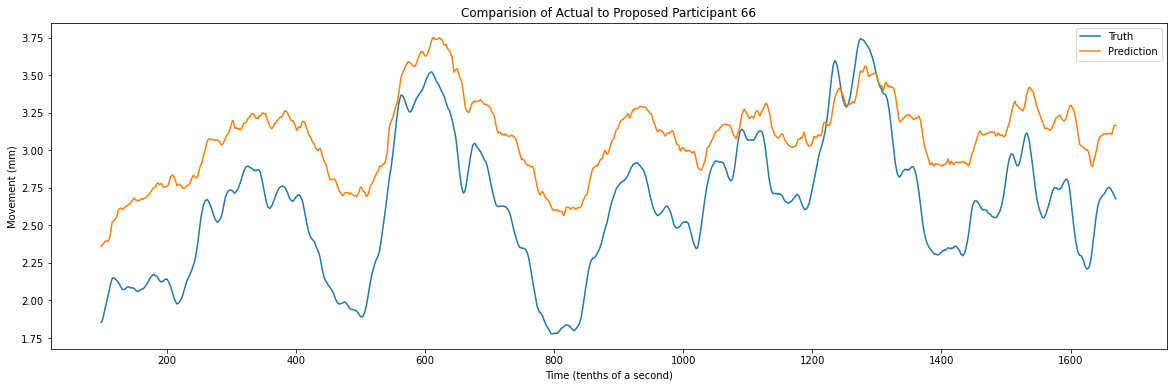

In [171]:
ind = 0
for par in test_y['PID'].unique():
    prediction = par_scores_df.loc[par_scores_df['par']==par, 'pred'][ind]
    truth = par_scores_df.loc[par_scores_df['par']==par, 'true'][ind]
    compare = pd.DataFrame({'Truth':truth, 'Prediction':prediction})
    compare.rolling(100).mean().plot(figsize=(20, 6))
    plt.title('Comparision of Actual to Proposed Participant {}'.format(par))
    plt.xlabel('Time (tenths of a second)')
    plt.ylabel('Movement (mm)')
    plt.show()
    ind +=1